In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import jax

import matplotlib.pyplot as plt

from pywbm.water_balance_jax import *

### Read climate data

In [109]:
# Read forcing data from the pyWBM input directory
##################################################################
# UDPATE THIS
# input_dir = "/Users/dcl257/Projects/pywbm_input_data/"
input_dir = "/data/keeling/a/davidcl2/d/pyWBM_data/"
##################################################################

forcing_data = "smap"
ds_forcing = xr.open_dataset(f"{input_dir}/{forcing_data}_forcing.nc")

ds_lai = xr.open_dataset(f"{input_dir}/LAI_GLDAS_clima_NLDASgrid.nc")

ds_params = xr.open_dataset(f"{input_dir}/pywbm_params.nc")
ds_Kpet = xr.open_dataset(f"{input_dir}/Kpet.nc")

In [110]:
# ds_forcing contains daily temperature [C] and precipitation [mm]
# measurements over CONUS from 2016-01-01 to 2022-12-31
print(ds_forcing)

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 2555, lat: 224, lon: 464)
Coordinates:
  * time     (time) object 20kB 2016-01-01 00:00:00 ... 2022-12-31 00:00:00
  * lat      (lat) float64 2kB 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
  * lon      (lon) float64 4kB -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
Data variables:
    tas      (time, lat, lon) float64 2GB ...
    pr       (time, lat, lon) float64 2GB ...
Attributes:
    regrid_method:  conservative


In [111]:
# ds_params contains calibrated pyWBM parameter values from Lafferty et al. (2025)
# each parameter can be indexed by `obs_name`, which indicates which dataset was
# used for that calibration, and `metric`, which indicates which loss function 
# was used.
print(ds_params)

<xarray.Dataset> Size: 173MB
Dimensions:   (obs_name: 4, metric: 13, lat: 224, lon: 464)
Coordinates:
  * obs_name  (obs_name) <U6 96B 'MOSAIC' 'NOAH' 'SMAP' 'VIC'
  * metric    (metric) <U13 676B 'kge' 'mae' 'mse' ... 'ubmae' 'ubmse' 'ubrmse'
  * lon       (lon) float64 4kB -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * lat       (lat) float64 2kB 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
Data variables:
    awCap     (obs_name, metric, lat, lon) float64 43MB ...
    wiltingp  (obs_name, metric, lat, lon) float64 43MB ...
    alpha     (obs_name, metric, lat, lon) float64 43MB ...
    beta_R    (obs_name, metric, lat, lon) float64 43MB ...


In [112]:
# ds_Kpet contains the 365-day timeseries of evapotranspiration modifiers, again
# from the calibrated parameter values from Lafferty et al. (2025) 
print(ds_Kpet)

<xarray.Dataset> Size: 8GB
Dimensions:   (obs_name: 4, metric: 13, doy: 365, lat: 224, lon: 464)
Coordinates:
  * obs_name  (obs_name) <U6 96B 'MOSAIC' 'NOAH' 'SMAP' 'VIC'
  * metric    (metric) <U13 676B 'kge' 'mae' 'mse' ... 'ubmae' 'ubmse' 'ubrmse'
  * lon       (lon) float32 2kB -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * lat       (lat) float32 896B 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
  * doy       (doy) int64 3kB 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
Data variables:
    Kpet      (obs_name, metric, doy, lat, lon) float32 8GB ...


In [113]:
# ds_Kpet contains the 365-day climatology of CONUS LAI values from GLDAS
print(ds_lai)

<xarray.Dataset> Size: 304MB
Dimensions:  (time: 365, lat: 224, lon: 464)
Coordinates:
  * time     (time) object 3kB 2000-01-01 00:00:00 ... 2000-12-31 00:00:00
  * lat      (lat) float64 2kB 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
  * lon      (lon) float64 4kB -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
Data variables:
    LAI      (time, lat, lon) float64 303MB ...
Attributes:
    regrid_method:  bilinear


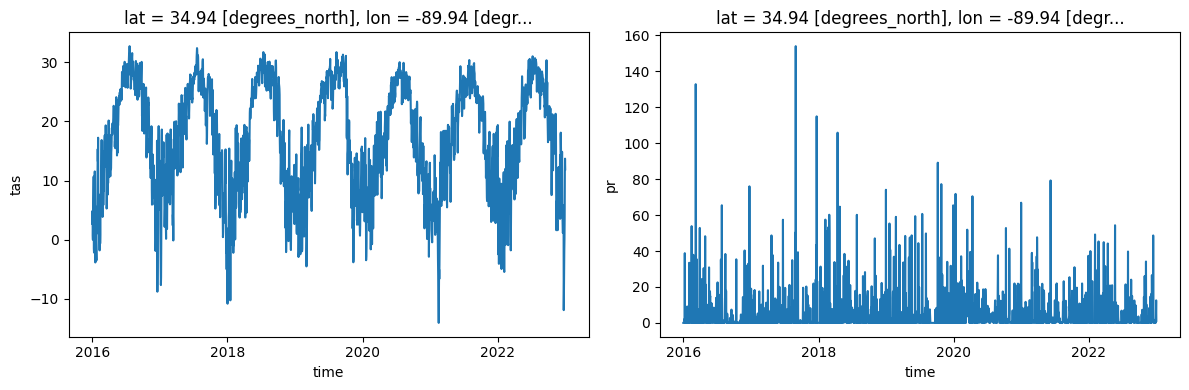

In [114]:
# Take a look at timeseries for random point
lat, lon = 35, -90
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ds_forcing.sel(lat=lat, lon=lon, method="nearest")["tas"].plot(ax=axs[0])
ds_forcing.sel(lat=lat, lon=lon, method="nearest")["pr"].plot(ax=axs[1])
plt.tight_layout()
plt.show()

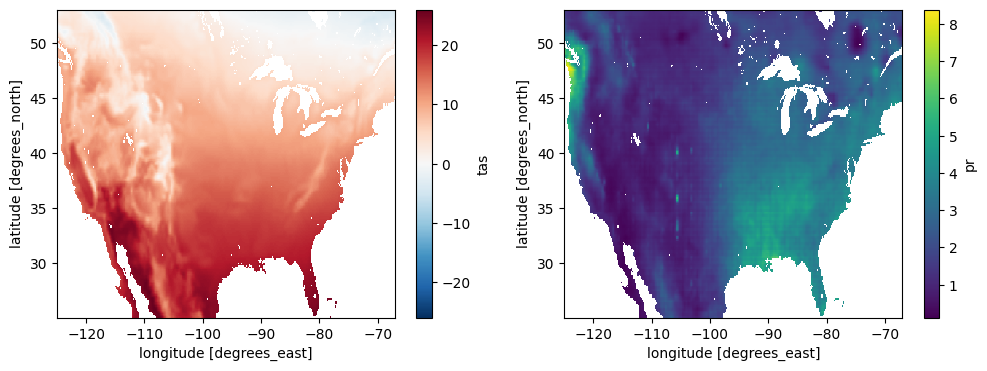

In [115]:
# Take a look at the long term averages
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ds_forcing["tas"].mean(dim="time").plot(ax=axs[0])
ds_forcing["pr"].mean(dim="time").plot(ax=axs[1])
plt.show()

### Realistic soil moisture simulation

The strategy for running pyWBM across space is to leverage JAX's native vectorization using the `vmap` function (https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html). Since pyWBM contains no lateral flow of water, we can simulate each pixel independently. `vmap` allows us to run the model across space in a vectorized manner, which is much faster than looping over each pixel. In order to do so, we need to take the 3-dimensional forcing data (lat/lon/time) and collapse (or stack) the two spatial dimensions into one, which provides `vmap` with a single axis to vectorize over. Similarly, for the other inputs to the model--parameters or initial conditions--we need to ensure that their spatial dimensions are similarly collapsed into a single axis. Then, after running the model, we can reshape or unstack the output back into the original dimensions.

Note that we could also use `pmap` (https://jax.readthedocs.io/en/latest/_autosummary/jax.pmap.html) here in order to parallelize this operation. This could be explored in future.

In [116]:
# Stack using xarray's stack method
tas = ds_forcing["tas"].stack(points=["lat", "lon"]).to_numpy().T
prcp = ds_forcing["pr"].stack(points=["lat", "lon"]).to_numpy().T

# Dimension of the simulation
nx = ds_forcing["lon"].size
ny = ds_forcing["lat"].size
nxy = nx * ny
nt = ds_forcing["time"].size

In [118]:
## Choose calibrated parameter set for simulation

# This should align with the forcing data, i.e.
# if you choose VIC, NOAH, MOSAIC here, you should
# use `nldas` for forcing above. If you choose SMAP 
# here you need to use smap above.
obs_name = "SMAP"

# Loss function used can be RMSE, MSE, KGE, ...
metric = "kge"

# Grab spatially varying parameters and format for passing to pyWBM
awCap = ds_params.sel(obs_name=obs_name, metric=metric)['awCap'].stack(points=["lat", "lon"]).to_numpy().T
wiltingp = ds_params.sel(obs_name=obs_name, metric=metric)['wiltingp'].stack(points=["lat", "lon"]).to_numpy().T
alpha = ds_params.sel(obs_name=obs_name, metric=metric)['alpha'].stack(points=["lat", "lon"]).to_numpy().T
betaHBV = ds_params.sel(obs_name=obs_name, metric=metric)['beta_R'].stack(points=["lat", "lon"]).to_numpy().T

Kpet = ds_Kpet.sel(obs_name=obs_name, metric=metric)['Kpet'].stack(points=["lat", "lon"]).to_numpy().T

lai = ds_lai['LAI'].stack(points=["lat", "lon"]).to_numpy().T

# Constant parameters
rootDepth = 1.0 
Ts = -1.0
Tm = 1.0

# Construct input dicts
theta = {
    "awCap": awCap,
    "wiltingp": wiltingp,
    "alpha": alpha,
    "betaHBV": betaHBV,
}
constants = {
    "Ts": np.tile(Ts, nxy),
    "Tm": np.tile(Tm, nxy),
    "rootDepth": np.tile(rootDepth, nxy),
    "phi": ds_forcing_stacked["lat"].to_numpy(),  # note this one is different because there is some spatial variation
}
params = {**theta, **constants}

forcing = {
    "tas": tas,
    "prcp": prcp,
    "Kpet": Kpet,
    "lai": lai,
}

In [119]:
# Initial conditions
init = {
    "Ws_init": wiltingp + awCap/2, # soils are half-full
    "Wi_init": np.tile(0.0, nxy),
    "Sp_init": np.tile(0.0, nxy),
}

In [120]:
# Make the vmap function
run_water_balance_vmap = jax.jit(jax.vmap(run_water_balance, in_axes=(0, 0, 0), out_axes=0))

In [121]:
%%time
# 7 year simulation length @ 12.5km resolution over CONUS
out = run_water_balance_vmap(forcing, init, params)

CPU times: user 25.2 s, sys: 2min 3s, total: 2min 28s
Wall time: 1min 13s


In [122]:
# Add outputs to the stacked array and then unstack
ds_out = xr.Dataset({'soilMoist': xr.full_like(ds_forcing["tas"].stack(points=["lat", "lon"]), 1.)})
ds_out["soilMoist"] = (("points", "time"), out)
ds_out = ds_out.unstack("points")

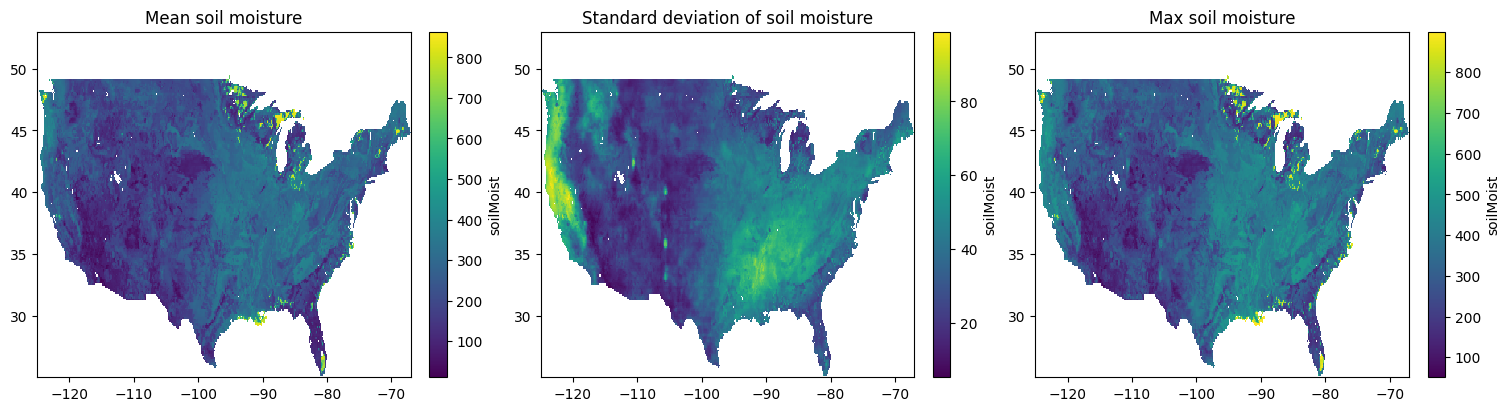

In [123]:
# Plot some summary statistics
fig, axs = plt.subplots(1, 3, figsize=(15, 4), layout='constrained')

ds_out["soilMoist"].mean(dim="time", skipna=False).plot(ax=axs[0])
axs[0].set_title("Mean soil moisture")

ds_out["soilMoist"].std(dim="time", skipna=False).plot(ax=axs[1])
axs[1].set_title("Standard deviation of soil moisture")

ds_out["soilMoist"].max(dim="time", skipna=False).plot(ax=axs[2])
axs[2].set_title("Max soil moisture")

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.show()

You can see here that we simulate quite complex soil moisture patterns given realistic input parameter that vary over space.

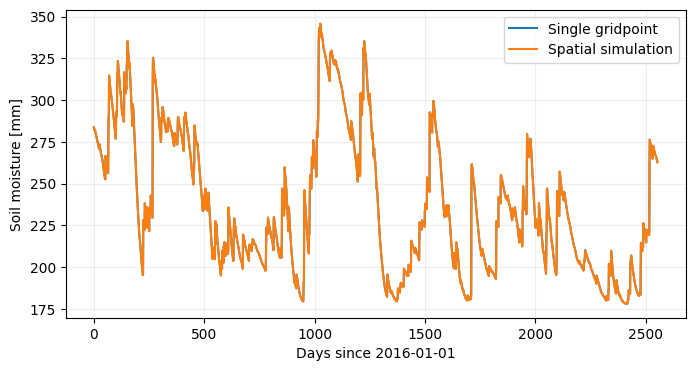

In [124]:
# Let's verify that the spatial simulation gives the same result as the point simulation.

# Choose a test gridpoint (vary this to see other location's outputs)
lat_isel = 50
lon_isel = 200


# Set up single gridpoint simulation with same parameters
params = {
    "awCap": awCap.reshape(ny, nx)[lat_isel, lon_isel],
    "wiltingp": wiltingp.reshape(ny, nx)[lat_isel, lon_isel],
    "alpha": alpha.reshape(ny, nx)[lat_isel, lon_isel],
    "betaHBV": betaHBV.reshape(ny, nx)[lat_isel, lon_isel],
    "Ts": Ts,
    "Tm": Tm,
    "rootDepth": rootDepth,
    "phi": ds_forcing.isel(lat=lat_isel, lon=lon_isel)["lat"].to_numpy(),
}

forcing = {
    "tas": ds_forcing.isel(lat=lat_isel, lon=lon_isel)["tas"].to_numpy(),
    "prcp": ds_forcing.isel(lat=lat_isel, lon=lon_isel)["pr"].to_numpy(),
    "Kpet": Kpet.reshape(ny, nx, 365)[lat_isel, lon_isel, :],
    "lai": ds_lai.isel(lat=lat_isel, lon=lon_isel)["LAI"].to_numpy(),
}

init = {
    "Ws_init": params["wiltingp"] + params["awCap"]/2.,
    "Wi_init": 0.0,
    "Sp_init": 0.0,
}

# Simulate soil moisture: single gridpoint
soilM_test = run_water_balance(
    forcing=forcing,
    init=init,
    params=params,
)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(soilM_test, label="Single gridpoint")
ax.plot(
    ds_out["soilMoist"].isel(lat=lat_isel, lon=lon_isel), label="Spatial simulation"
)
ax.set_ylabel("Soil moisture [mm]")
ax.set_xlabel("Days since 2016-01-01")
ax.legend()
ax.grid(alpha=0.2)
plt.show()